In [1]:
################################################################################
#Michael Guerzhoy, 2016
#AlexNet implementation in TensorFlow, with weights
#Details: 
#http://www.cs.toronto.edu/~guerzhoy/tf_alexnet/
#
#With code from https://github.com/ethereon/caffe-tensorflow
#Model from  https://github.com/BVLC/caffe/tree/master/models/bvlc_alexnet
#Weights from Caffe converted using https://github.com/ethereon/caffe-tensorflow
#
#
################################################################################

from numpy import *
import os
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import time
from scipy.misc import imread
from scipy.misc import imresize
import matplotlib.image as mpimg
from scipy.ndimage import filters
import urllib
from numpy import random

import tensorflow as tf

from caffe_classes import class_names

In [4]:
def conv(input, kernel, biases, k_h, k_w, c_o, s_h, s_w,  padding="VALID", group=1):
    '''From https://github.com/ethereon/caffe-tensorflow
    '''
    c_i = input.get_shape()[-1]
    assert c_i%group==0
    assert c_o%group==0
    convolve = lambda i, k: tf.nn.conv2d(i, k, [1, s_h, s_w, 1], padding=padding)
    
    
    if group==1:
        conv = convolve(input, kernel)
    else:
        input_groups = tf.split(3, group, input)
        kernel_groups = tf.split(3, group, kernel)
        output_groups = [convolve(i, k) for i,k in zip(input_groups, kernel_groups)]
        conv = tf.concat(3, output_groups)
    return  tf.reshape(tf.nn.bias_add(conv, biases), conv.get_shape().as_list())



def alexnet(x):
    # x = tf.Variable(i)
    net_data = load("bvlc_alexnet.npy").item()

    layers = {}
    #conv1
    #conv(11, 11, 96, 4, 4, padding='VALID', name='conv1')
    k_h = 11; k_w = 11; c_o = 96; s_h = 4; s_w = 4
    conv1W = tf.Variable(net_data["conv1"][0])
    conv1b = tf.Variable(net_data["conv1"][1])
    conv1_in = conv(x, conv1W, conv1b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=1)
    conv1 = tf.nn.relu(conv1_in)

    layers['conv1'] = conv1_in
    #lrn1
    #lrn(2, 2e-05, 0.75, name='norm1')
    radius = 2; alpha = 2e-05; beta = 0.75; bias = 1.0
    lrn1 = tf.nn.local_response_normalization(conv1,
                                                      depth_radius=radius,
                                                      alpha=alpha,
                                                      beta=beta,
                                                      bias=bias)

    layers['lrn1'] = lrn1
    #maxpool1
    #max_pool(3, 3, 2, 2, padding='VALID', name='pool1')
    k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
    maxpool1 = tf.nn.max_pool(lrn1, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)

    layers['maxpool1'] = maxpool1

    #conv2
    #conv(5, 5, 256, 1, 1, group=2, name='conv2')
    k_h = 5; k_w = 5; c_o = 256; s_h = 1; s_w = 1; group = 2
    conv2W = tf.Variable(net_data["conv2"][0])
    conv2b = tf.Variable(net_data["conv2"][1])
    conv2_in = conv(maxpool1, conv2W, conv2b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
    conv2 = tf.nn.relu(conv2_in)

    layers['conv2'] = conv2_in
    #lrn2
    #lrn(2, 2e-05, 0.75, name='norm2')
    radius = 2; alpha = 2e-05; beta = 0.75; bias = 1.0
    lrn2 = tf.nn.local_response_normalization(conv2,
                                                      depth_radius=radius,
                                                      alpha=alpha,
                                                      beta=beta,
                                                      bias=bias)

    layers['lrn2'] = lrn2
    #maxpool2
    #max_pool(3, 3, 2, 2, padding='VALID', name='pool2')                                                  
    k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
    maxpool2 = tf.nn.max_pool(lrn2, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)

    layers['maxpool2'] = maxpool2
    #conv3
    #conv(3, 3, 384, 1, 1, name='conv3')
    k_h = 3; k_w = 3; c_o = 384; s_h = 1; s_w = 1; group = 1
    conv3W = tf.Variable(net_data["conv3"][0])
    conv3b = tf.Variable(net_data["conv3"][1])
    conv3_in = conv(maxpool2, conv3W, conv3b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
    conv3 = tf.nn.relu(conv3_in)

    #conv4
    #conv(3, 3, 384, 1, 1, group=2, name='conv4')
    k_h = 3; k_w = 3; c_o = 384; s_h = 1; s_w = 1; group = 2
    conv4W = tf.Variable(net_data["conv4"][0])
    conv4b = tf.Variable(net_data["conv4"][1])
    conv4_in = conv(conv3, conv4W, conv4b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
    conv4 = tf.nn.relu(conv4_in)


    #conv5
    #conv(3, 3, 256, 1, 1, group=2, name='conv5')
    k_h = 3; k_w = 3; c_o = 256; s_h = 1; s_w = 1; group = 2
    conv5W = tf.Variable(net_data["conv5"][0])
    conv5b = tf.Variable(net_data["conv5"][1])
    conv5_in = conv(conv4, conv5W, conv5b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
    conv5 = tf.nn.relu(conv5_in)

    #maxpool5
    #max_pool(3, 3, 2, 2, padding='VALID', name='pool5')
    k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
    maxpool5 = tf.nn.max_pool(conv5, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)

    #fc6
    #fc(4096, name='fc6')
    fc6W = tf.Variable(net_data["fc6"][0])
    fc6b = tf.Variable(net_data["fc6"][1])
    maxpool5_re = tf.reshape(maxpool5, [1, int(prod(maxpool5.get_shape()[1:]))])
    fc6_in = tf.nn.xw_plus_b(maxpool5_re,fc6W,fc6b)
    fc6 = tf.nn.relu(fc6_in)
#     fc6 = tf.nn.relu_layer(maxpool5_re, fc6W, fc6b)

    #fc7
    #fc(4096, name='fc7')
    fc7W = tf.Variable(net_data["fc7"][0])
    fc7b = tf.Variable(net_data["fc7"][1])
#     fc7 = tf.nn.relu_layer(fc6, fc7W, fc7b)
    fc7_in = tf.nn.xw_plus_b(fc6,fc7W,fc7b)
    fc7 = tf.nn.relu(fc7_in)

    #fc8
    #fc(1000, relu=False, name='fc8')
    fc8W = tf.Variable(net_data["fc8"][0])
    fc8b = tf.Variable(net_data["fc8"][1])
    fc8 = tf.nn.xw_plus_b(fc7, fc8W, fc8b)

    layers['conv3'] = conv3_in
    layers['conv4'] = conv4_in
    layers['conv5'] = conv5_in
    layers['maxpool5'] = maxpool5
    layers['fc6'] = fc6_in
    layers['fc7'] = fc7_in
    layers['fc8'] = fc8
    #prob
    #softmax(name='prob'))
    prob = tf.nn.softmax(fc8)
    return prob,layers

In [5]:
import tensorflow as tf
train_x = np.zeros((1, 227,227,3)).astype(float)
train_y = np.zeros((1, 1000))
xdim = train_x.shape[1:]
ydim = train_y.shape[1]
x = tf.placeholder(tf.float32,[1,227,227,3])

prob,layers = alexnet(x)

init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

In [48]:
x_dummy = (np.random.random((1,)+ xdim)/255.).astype(float)
i = x_dummy.copy()
i[0,:,:,:] = (imread("poodle.png")[:,:,:3]).astype(float)
i = i-mean(i)

output = sess.run(prob,feed_dict={x:i})
################################################################################

#Output:

inds = argsort(output)[0,:]
for i in range(5):
    print class_names[inds[-1-i]], output[0, inds[-1-i]]

miniature poodle 0.389457
toy poodle 0.223091
Bedlington terrier 0.173047
standard poodle 0.149645
komondor 0.0258336


In [7]:
import os
import os.path
import random

vdir = '/media/kabram/My Passport/imagenet/ILSVRC2012_img_val'

vfiles = [os.path.join(vdir,ff) for ff in os.listdir(vdir)]
random.shuffle(vfiles)
print vfiles[0:3]

['/media/kabram/My Passport/imagenet/ILSVRC2012_img_val/ILSVRC2012_val_00017587.JPEG', '/media/kabram/My Passport/imagenet/ILSVRC2012_img_val/ILSVRC2012_val_00030974.JPEG', '/media/kabram/My Passport/imagenet/ILSVRC2012_img_val/ILSVRC2012_val_00047413.JPEG']


In [8]:
print layers.keys()
print layers['fc6'].get_shape().as_list()

['fc6', 'conv2', 'fc8', 'fc7', 'conv1', 'conv3', 'lrn1', 'lrn2', 'conv5', 'conv4', 'maxpool5', 'maxpool1', 'maxpool2']
[1, 4096]


In [100]:
lsel = ['conv2','conv3','conv4','conv5','fc6','fc7']
out = {}
ncount = 5000

vals = {}
outvar = []
for ll in lsel:
    vals[ll] = np.zeros([ncount,]+layers[ll].get_shape().as_list())
    outvar.append(layers[ll])
    
for ndx in range(ncount):
    isz = np.array([227,227])
    inImg = imread(vfiles[ndx])
    if len(inImg.shape)<3:
        inImg = np.tile(inImg[:,:,np.newaxis],[1,1,3])
    i = (inImg[:,:,:3]).astype(float)
    ir = imresize(i,isz)
    out = sess.run(outvar,feed_dict={x:ir[np.newaxis,...]})
    for lndx,ll in enumerate(lsel):
        vals[ll][ndx,...] = out[lndx]


In [50]:
net_data = load("bvlc_alexnet.npy").item()


(1000, 1, 13, 13, 384)
(169000,)
[3697.881619490864] [ 0.] 0.00752645 294
[0.32716501983528234] [ 0.84909644]


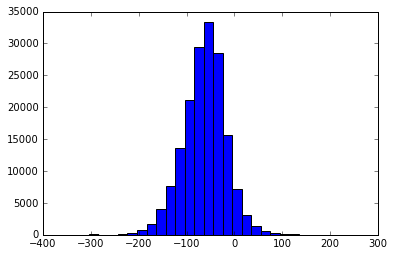

(array([   2.,    6.,    8.,   24.,   32.,   47.,   80.,  138.,  203.,
         245.,  299.,  364.,  404.,  463.,  470.,  487.,  428.,  390.,
         286.,  197.,  155.,  108.,   68.,   45.,   21.,   12.,   12.,
           3.,    0.,    3.]),
 array([ -2.83229429e+01,  -2.59623196e+01,  -2.36016964e+01,
         -2.12410731e+01,  -1.88804499e+01,  -1.65198266e+01,
         -1.41592034e+01,  -1.17985802e+01,  -9.43795692e+00,
         -7.07733367e+00,  -4.71671043e+00,  -2.35608719e+00,
          4.53605275e-03,   2.36515929e+00,   4.72578254e+00,
          7.08640578e+00,   9.44702902e+00,   1.18076523e+01,
          1.41682755e+01,   1.65288987e+01,   1.88895220e+01,
          2.12501452e+01,   2.36107685e+01,   2.59713917e+01,
          2.83320150e+01,   3.06926382e+01,   3.30532614e+01,
          3.54138847e+01,   3.77745079e+01,   4.01351312e+01,
          4.24957544e+01]),
 <a list of 30 Patch objects>)

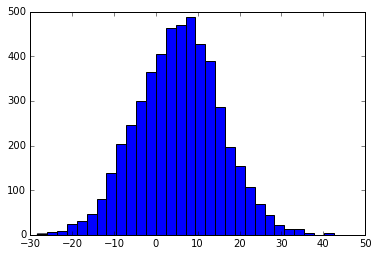

In [71]:
import scipy
import scipy.stats

lname = 'conv3'
print vals[lname].shape
fndx = np.random.randint(0,vals[lname].shape[-1])
bb = net_data[lname][1][fndx]
a = vals[lname][...,fndx].flatten()
plt.hist(a,bins=30)
print a.shape
[k,p] = scipy.stats.mstats.normaltest(a[:,np.newaxis],0)
print k,p,bb,fndx
ss = np.random.randn(5000,1)*10+5
[k,p] = scipy.stats.mstats.normaltest(ss,0)
print k,p
plt.show()
plt.hist(ss,bins=30)


In [112]:
import scipy
import scipy.stats

mm = []
vv = []
bb = []
for lndx,lname in enumerate(lsel):
    nd = vals[lname].shape[-1]
    vv.append(np.zeros([nd,1]))
    mm.append(np.zeros([nd,1]))
    bb.append(np.zeros([nd,1]))
    for ndx in range(nd):
        gg = vals[lname][...,ndx].flatten()[:,newaxis]
        vv[lndx][ndx,0] = np.std(gg)
        mm[lndx][ndx,0] = np.median(gg)
        bb[lndx][ndx,0] = net_data[lname][1][ndx]

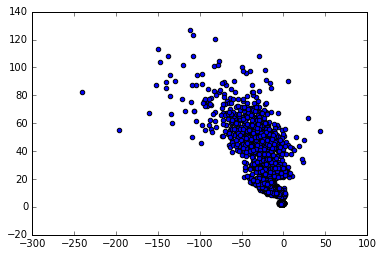

In [103]:
amm = np.concatenate(mm)
avv = np.concatenate(vv)
abb = np.concatenate(bb)
plt.scatter(amm-abb,avv)

In [85]:
kk = gg.flatten()[:,np.newaxis]
print kk.shape
ss = np.var(kk)
print ss

(169000, 1)
2760.98091534


(array([  1.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          1.90000000e+01,   5.30000000e+01,   1.87000000e+02,
          5.78000000e+02,   1.29900000e+03,   2.01300000e+03,
          2.29000000e+03,   1.66500000e+03,   9.22000000e+02,
          3.20000000e+02,   9.40000000e+01,   2.10000000e+01,
          4.00000000e+00,   3.00000000e+00]),
 array([-3.55106793, -3.33354897, -3.11603001, -2.89851105, -2.68099209,
        -2.46347313, -2.24595417, -2.02843521, -1.81091625, -1.59339729,
        -1.37587833, -1.15835937, -0.94084041, -0.72332145, -0.50580249,
        -0.28828353, -0.07076457,  0.14675439,  0.36427335,  0.58179231,
         0.79931127]),
 <a list of 20 Patch objects>)

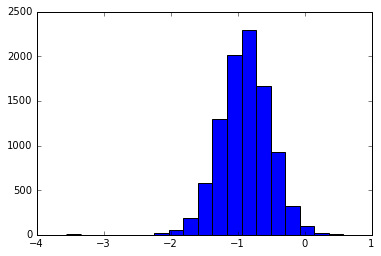

In [104]:
plt.hist((amm-abb)/avv,bins=20)

In [121]:
kk = np.corrcoef(mm[ndx].flatten()-bb[ndx].flatten(),vv[ndx].flatten())
print kk

[[ 1.        -0.4202118]
 [-0.4202118  1.       ]]
(256, 1)


['conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7']
[[-0.42007326]
 [-0.36131123]
 [-0.32617075]
 [-0.25897576]
 [-0.57366982]
 [-0.12248846]]


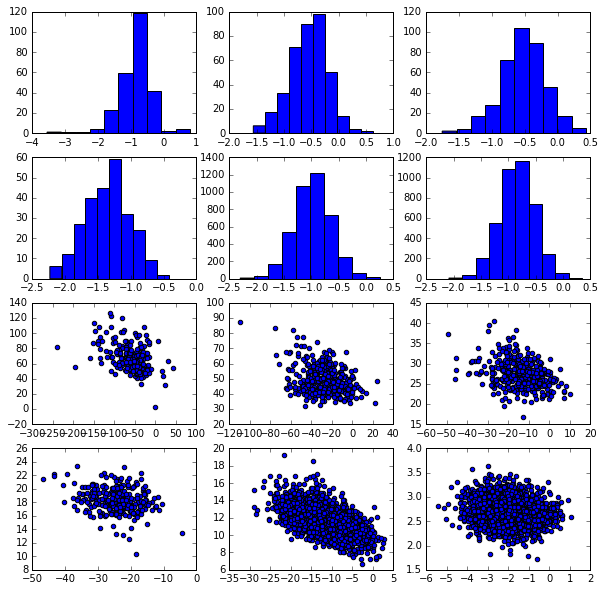

In [123]:
fig = figure(figsize=[10,10])
nl = len(mm)
print lsel
cc = np.zeros([len(mm),1])
for ndx in range(len(mm)):
    ax = fig.add_subplot(4,nl/2,ndx+1)
    ax.hist((mm[ndx]-bb[ndx])/vv[ndx])
    ax = fig.add_subplot(4,nl/2,ndx+nl+1)
#     ax.scatter(mm[ndx]-bb[ndx],vv[ndx])
    ax.scatter(mm[ndx],vv[ndx])
    cc[ndx,0] = np.corrcoef(mm[ndx].flatten().flatten(),vv[ndx].flatten())[0,1]
print cc

['conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7']


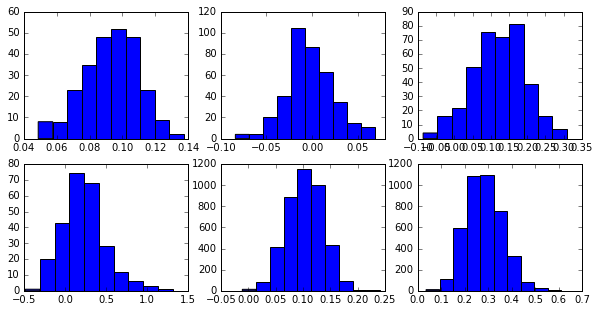

In [128]:
fig = figure(figsize=[10,5])
print lsel
for ndx in range(len(mm)):
    ax = fig.add_subplot(2,nl/2,ndx+1)
    ax.hist((bb[ndx]))
